<a href="https://colab.research.google.com/github/amousavi9/Breast_Segmentation_UNet/blob/main/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tf_explain

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
## Making essential imports
import cv2
import os
import glob
from tqdm import tqdm
import numpy as np
np.random.seed = 42
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras import layers
from tensorflow.keras.utils import plot_model
from tf_explain.core.grad_cam import GradCAM
from sklearn.model_selection import train_test_split

##Data Preprocessing

In [81]:
## root directory
root_dir = '/content/drive/MyDrive/breast-ultrasound-dataset/Dataset_BUSI_with_GT'
os.listdir(root_dir)

['benign', 'malignant', 'normal']

In [82]:
IMG_WIDTH = 128
IMG_HIGH = 128
IMG_CHANNELS = 3 # number of input channels

EPOCHS = 200

In [83]:
def LoadData(root_dir, FolderName, img_width=IMG_WIDTH, img_high=IMG_HIGH, img_channels=IMG_CHANNELS):
  num_samples = 0
  for address in glob.glob(root_dir + f'/{FolderName}/*'):
    s_address = address.split()[-1]
    s_address = s_address.split('.')[0]
    s_address = s_address.split('_')
    if len(s_address) == 1:
      num_samples += 1

  X = np.zeros((num_samples, img_high, img_width, img_channels), dtype=np.uint8)
  Y = np.zeros((num_samples, img_high, img_width, 1), dtype=np.bool8)


  for address in tqdm(glob.glob(root_dir + f'/{FolderName}/*')):
    img = cv2.imread(address)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(img, (img_width, img_high), interpolation=cv2.INTER_CUBIC)

    s_address = address.split()[-1]
    s_address = s_address.split('.')[0]
    s_address = s_address.split('_')

    idx = s_address[0]
    idx = int(idx.split('(')[1].split(')')[0]) - 1

    if len(s_address) == 1:
      X[idx] = resized_image
      
    elif len(s_address) > 1:
      mask = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
      
      mask = np.expand_dims(mask, axis=-1)
      Y[idx] = np.maximum(mask, Y[idx])

  return X, Y

In [84]:
x_benign, y_benign = LoadData(root_dir, 'benign')
x_malignant, y_malignant = LoadData(root_dir, 'malignant')
x_normal, y_normal = LoadData(root_dir, 'normal')

X = np.concatenate((x_benign, x_malignant, x_normal), axis=0)
Y = np.concatenate((y_benign, y_malignant, y_normal), axis=0)

100%|██████████| 266/266 [00:02<00:00, 117.28it/s]


In [85]:
X.shape, Y.shape

((780, 128, 128, 3), (780, 128, 128, 1))

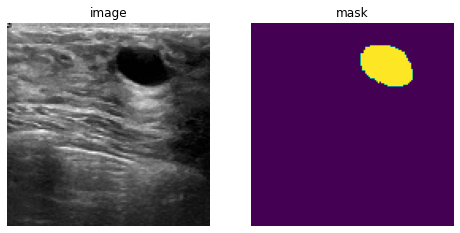

In [86]:
## displaying data loaded by our function
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.imshow(X[138])
plt.title('image')
plt.axis('off');

plt.subplot(1,2,2)
plt.imshow(tf.squeeze(Y[138]))
plt.title('mask')
plt.axis('off');

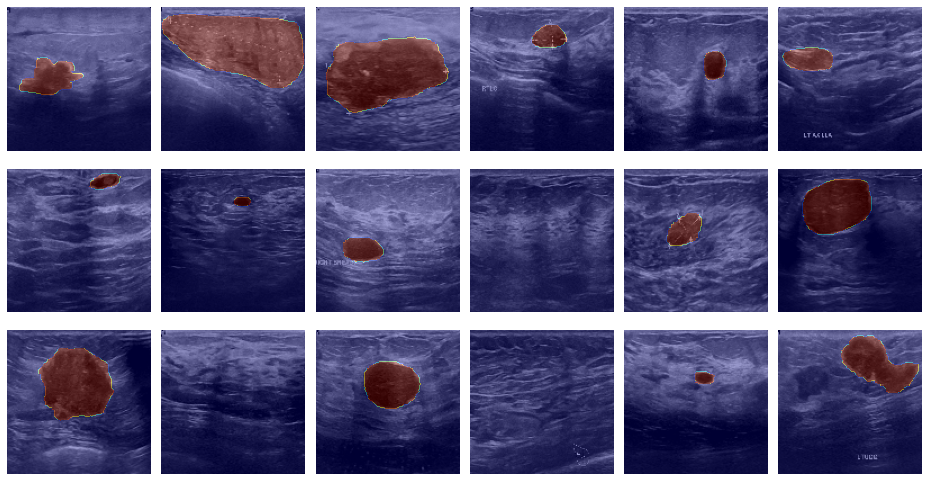

In [10]:
plt.figure(figsize=(13,7))
for i in range(18):
    plt.subplot(3,6,i+1)
    idx = np.random.randint(0, len(X))
    plt.imshow(X[idx])
    plt.imshow(tf.squeeze(Y[idx]), cmap='jet', alpha=0.4)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, shuffle=True)

##U-Net Model

In [44]:
def Conv_Block(inputs, num_filters, kernel_size=3):

    x = tf.keras.layers.Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size),
                              kernel_initializer = 'he_normal', padding = 'same') (inputs)
    x =tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [45]:
inputs = keras.layers.Input(shape=(IMG_HIGH, IMG_WIDTH, IMG_CHANNELS))
inputs_ = layers.Lambda(lambda x: x/255.0)(inputs)

#Contraction path
conv1 = Conv_Block(inputs_, 16)
pool1 = layers.MaxPooling2D((3,3), strides = 2, padding = 'same')(conv1)
drop1 = layers.Dropout(0.2)(pool1)

conv2 = Conv_Block(drop1, 32)
pool2 = layers.MaxPooling2D((3,3), strides = 2, padding = 'same')(conv2)
drop2 = layers.Dropout(0.2)(pool2)

conv3 = Conv_Block(drop2, 64)
pool3 = layers.MaxPooling2D((2,2), strides = 2, padding = 'same')(conv3)
drop3 = layers.Dropout(0.1)(pool3)

conv4 = Conv_Block(drop3, 128)
pool4 = layers.MaxPooling2D((2,2), strides = 2, padding = 'same')(conv4)
drop4 = layers.Dropout(0.1)(pool4)

conv5 = Conv_Block(drop4, 256)
pool5 = layers.MaxPooling2D((2,2), strides = 2, padding = 'same')(conv5)
drop5 = layers.Dropout(0.1)(pool5)

conv6 = Conv_Block(drop5, 512)
drop6 = layers.Dropout(0.1)(conv6)

#Expansion path 
tran6 = layers.Conv2DTranspose(256, (2, 2), strides = (2, 2), padding = 'same')(drop5)
conc6 = layers.concatenate([tran6, conv5])
drop6 = layers.Dropout(0.1)(conc6)
conv6 = Conv_Block(drop6, 128)

tran7 = layers.Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(drop6)
conc7 = layers.concatenate([tran7, conv4])
drop7 = layers.Dropout(0.1)(conc7)
conv7 = Conv_Block(drop7, 64)

tran8 = layers.Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(drop7)
conc8 = layers.concatenate([tran8, conv3])
drop8 = layers.Dropout(0.1)(conc8)
conv8 = Conv_Block(drop8, 32)

tran9 = layers.Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same')(drop8)
conc9 = layers.concatenate([tran9, conv2])
drop9 = layers.Dropout(0.2)(conc9)
conv9 = Conv_Block(drop9, 16)

tran10 = layers.Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(drop9)
conc10 = layers.concatenate([tran10, conv1])
drop10 = layers.Dropout(0.2)(conc10)
conv10 = Conv_Block(drop10, 16)

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv10)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
plot_model(model, './model_plot.png', show_shapes = True)

In [47]:
callbacks = [
        tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', monitor = 'val_loss', verbose=1, save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/200
42/42 [==============================] - ETA: 0s - loss: 0.2949 - accuracy: 0.9179
Epoch 1: val_loss improved from inf to 0.20262, saving model to model_for_nuclei.h5
42/42 [==============================] - 33s 84ms/step - loss: 0.2949 - accuracy: 0.9179 - val_loss: 0.2026 - val_accuracy: 0.9302
Epoch 2/200
41/42 [============================>.] - ETA: 0s - loss: 0.2150 - accuracy: 0.9213
Epoch 2: val_loss improved from 0.20262 to 0.19527, saving model to model_for_nuclei.h5
42/42 [==============================] - 2s 44ms/step - loss: 0.2155 - accuracy: 0.9211 - val_loss: 0.1953 - val_accuracy: 0.9322
Epoch 3/200
41/42 [============================>.] - ETA: 0s - loss: 0.2083 - accuracy: 0.9241
Epoch 3: val_loss improved from 0.19527 to 0.18970, saving model to model_for_nuclei.h5
42/42 [==============================] - 2s 44ms/step - loss: 0.2103 - accuracy: 0.9231 - val_loss: 0.1897 - val_accuracy: 0.9321
Epoch 4/200
41/42 [============================>.] - ETA: 0s - l

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=/content/logs

##Testing

In [48]:
def predict_func(model, image, mask):
  y_pred = model.predict(image[np.newaxis,...])

  exp = GradCAM()
  pred_mask = model.predict(image[np.newaxis,...])
  cam = exp.explain(
      validation_data=(image[np.newaxis,...], mask),
      class_index=1,
      layer_name = model.layers[-1].name,
      model=model
  )

  return y_pred, cam

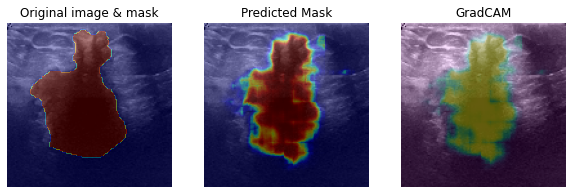

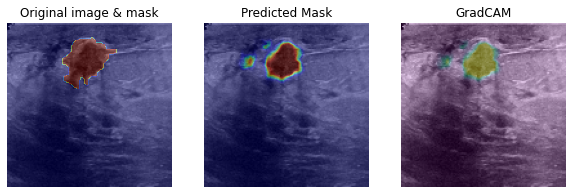

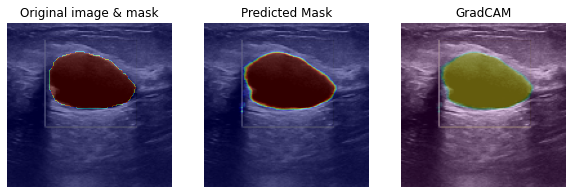

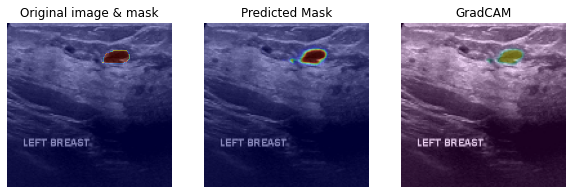

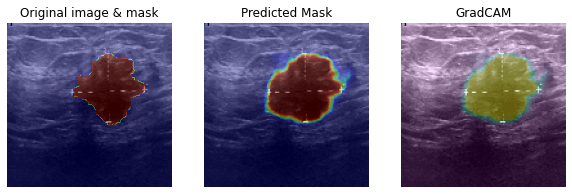

In [65]:
for i in range(5):
    id = np.random.randint(len(X_test))
    image = X_test[id]
    mask = y_test[id]
    pred_mask, cam = predict_func(model, image, mask)

    plt.figure(figsize=(10,8))
    plt.subplot(1,3,1)
    plt.title("Original image & mask")
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap='jet', alpha=0.4)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Predicted Mask")
    plt.imshow(image)
    plt.imshow(tf.squeeze(pred_mask), cmap='jet', alpha=0.4)
    plt.axis('off')
  
    plt.subplot(1,3,3)
    plt.title("GradCAM")
    plt.imshow(image)
    plt.imshow(cam, cmap='jet', alpha=0.4)
    plt.axis('off')

##Save Model

In [66]:
model.save('UNet.h5')